In [1]:
import os
import copy
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.datasets import DatasetFolder, ImageFolder
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
#from skimage import io, transform
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
n_class = 3
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print('device:', device)

device: cuda:0


In [19]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((224, 256), scale=(0.9, 1.1), ratio=(0.8,1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225)),
])
val_transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 256)),   
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225)),
])

test_transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((224, 256), scale=(0.9, 1.1), ratio=(0.8,1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225)),
])

trainset = ImageFolder('car-damage-dataset/data3a/training', transform=train_transform)
valset = ImageFolder('car-damage-dataset/data3a/validation', transform=val_transform)
testset = ImageFolder('car-damage-dataset/data3a/validation', transform=test_transform)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=1)
val_loader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=1)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=1)

[[1 2 2 0 1 1 2 2]
 [0 2 2 2 1 1 2 2]]


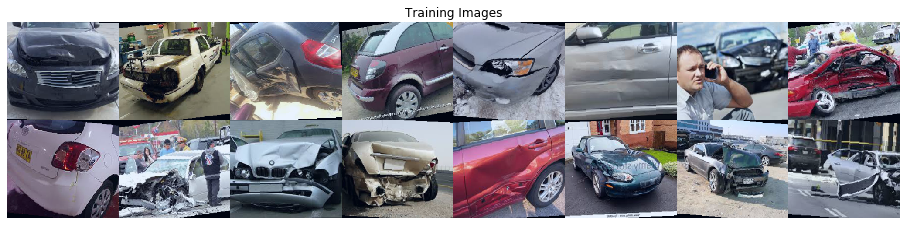

In [13]:
batch = next(iter(train_loader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:16], padding=0, normalize=True).cpu(),(1,2,0)))
print(batch[1].numpy()[:16].reshape(2,8))

In [16]:
def train(train_loader, val_loader=None, model=None, epoch=1, optimizer=None, criterion=None, early_stopping=3, device=device):
        
    best_loss = 10000000
    best_epoch = 0
    best_model_wts = None
    
    for t in range(epoch):
        
        model.train()
        
        for i_batch, batch in tqdm(enumerate(train_loader)):
            
            batch_X, batch_y = batch[0].to(device), batch[1].to(device)
            batch_y_pred = model(batch_X)
            loss = criterion(batch_y_pred, batch_y)
            #loss = criterion(batch_y_pred, batch_y.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if val_loader is not None: #evaluate on validation data
            
            model.eval()
            running_loss = 0.0
            with torch.no_grad():
                for i_batch, batch in enumerate(val_loader):
                    batch_X, batch_y = batch[0].to(device), batch[1].to(device)
                    batch_y_pred = model(batch_X)
                    loss = criterion(batch_y_pred, batch_y) 
                    #loss = criterion(batch_y_pred, batch_y.float())
                    running_loss += loss.item() * batch_X.size()[0]
        
            epoch_loss = running_loss / len(val_loader.dataset)
            print ("epoch %d, loss %.6f"%(t, epoch_loss))
            
            if epoch_loss < best_loss: #keep track of best loss and epoch
                best_loss = epoch_loss
                best_epoch = t
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if (t - best_epoch > early_stopping): #early stopping if loss haven't improve for n=early_stopping rounds
                break
                
    if best_model_wts is not None:
        print("load best weights from epoch %d"%best_epoch)
        model.load_state_dict(best_model_wts)

In [29]:
from torchvision import models
model = models.vgg16(pretrained=True)

# Freeze training for all layers
for param in model.features.parameters():
    param.requires_grad = False

# Newly created modules have require_grad=True by default
num_features = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(True),
    nn.Linear(128, n_class)
)

# num_features = model.classifier[6].in_features
# features = list(model.classifier.children())[:-1] # Remove last layer
# features.extend([nn.Linear(num_features, n_class)]) # Add our layer with 3 outputs
# model.classifier = nn.Sequential(*features) # Replace the model classifier

model = model.to(device)

if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ubuntu/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:22<00:00, 24.4MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.5, 0.999))
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

criterion = nn.CrossEntropyLoss()
train(train_loader, val_loader, model=model, epoch=20, optimizer=optimizer, criterion=criterion, early_stopping=5)

31it [00:07,  4.10it/s]


epoch 0, loss 0.832111


31it [00:07,  4.20it/s]


epoch 1, loss 0.748690


31it [00:07,  4.21it/s]


epoch 2, loss 0.877203


31it [00:07,  4.20it/s]


epoch 3, loss 0.894574


31it [00:07,  4.21it/s]


epoch 4, loss 0.857074


31it [00:07,  4.20it/s]


epoch 5, loss 0.990584


31it [00:07,  4.20it/s]


epoch 6, loss 1.080074


31it [00:07,  4.20it/s]


epoch 7, loss 1.011984
load best weights from epoch 1


In [27]:
def cls_predict(dataloader, model, n_class=None, index=True):
    model.eval()
    N = len(dataloader.dataset)
    b = dataloader.batch_size
    if index:
        result = np.zeros([N])
    else:
        assert n_class != None, "need to know output shape=n_class"
        result = np.zeros([N,n_class])
    with torch.no_grad():
        for i_batch, batch in tqdm(enumerate(dataloader)):
            batch_x = batch[0].to(device)
            batch_y_pred = model(batch_x)
            if index:
                _, idx = torch.max(batch_y_pred, 1)
                idx = idx.cpu().numpy()
                result[i_batch*b: min((i_batch+1)*b, N)] = idx
            else:
                result[i_batch*b: min((i_batch+1)*b, N)] = batch_y_pred.cpu().numpy()
    return result

def reg_predict(dataloader, model):
    model.eval()
    res = []
    with torch.no_grad():
        for i_batch, batch in tqdm(enumerate(dataloader)):
            batch_x = batch[0].to(device)
            batch_y_pred = model(batch_x)
            idx = batch_y_pred.view(-1).round()
            
            res += list(idx.cpu().numpy())
    return np.array(res)

In [31]:
# from scipy.special import softmax
# result = np.zeros([len(test_loader.dataset), n_class])
# N = 3
# for i in range(N):
#     pred = cls_predict(test_loader, model, n_class=n_class, index=False)
#     print(sum(pred))
#     result += softmax(pred)/N
# result = result.argmax(axis=1)

result = cls_predict(val_loader, model)

label = []
for i_batch, batch in tqdm(enumerate(val_loader)):
    label += list(batch[1].numpy())
label = np.array(label)

accuracy = sum(result==label)/len(label)
accuracy

3it [00:01,  1.73it/s]
3it [00:00,  6.14it/s]


0.6374269005847953

              precision    recall  f1-score   support

           0       0.63      0.77      0.69        48
           1       0.47      0.29      0.36        55
           2       0.72      0.82      0.77        68

    accuracy                           0.64       171
   macro avg       0.61      0.63      0.61       171
weighted avg       0.61      0.64      0.61       171



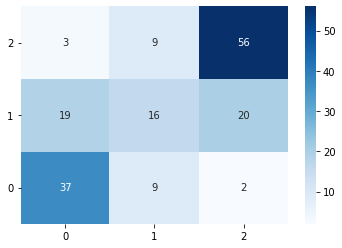

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(label, result))
ax = sns.heatmap(confusion_matrix(label, result), cmap='Blues', annot=True)
plt.yticks(rotation=0)
ax.set_ylim(0, 3)
plt.show()